In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pykalman import KalmanFilter

In [2]:
file_path = '/Users/annapham/Downloads/FilteredDailyMood.xlsx'

In [3]:
df = pd.read_excel(file_path)

In [4]:
# Filter the df for user_name 'bawtpe'
patient_df = df[df['user_name'] == 'bawtpe']

In [5]:
rating_cols = [
    "depressedMood",
    "fatigue",
    "fidgeting",
    "increasedEnergy",
    "rapidSpeech",
    "irritability"
]

patient_data = patient_df[rating_cols]

In [6]:
# Convert the patient_data DataFrame to a NumPy array
M = patient_data.to_numpy()
print("Shape of array M:", M.shape)

Shape of array M: (42, 6)


In [7]:
# Convert NaNs to masked values
M_masked = np.ma.masked_invalid(M) 

T, obs_dim = M.shape
latent_dim = 2

In [8]:
# Initial model parameters 
latent_dim = 2
obs_dim = 6

F0 = np.array([[0.5, 0.0],   # B
               [0.0, 0.5]])

H0 = np.array([[1.0, 0.0],   # A
               [1.0, 0.0],
               [1.0, 0.0],
               [0.0, 1.0],
               [0.0, 1.0],
               [0.5, 0.5]])

Q0 = 0.01 * np.eye(latent_dim)  # Gamma
R0 = 0.1  * np.eye(obs_dim)     # Sigma
x0 = np.zeros(latent_dim)
P0 = np.eye(latent_dim)

In [9]:
# Kalman Filter setup
kf = KalmanFilter(
    transition_matrices=F0,
    observation_matrices=H0,
    transition_covariance=Q0,
    observation_covariance=R0,
    initial_state_mean=x0,
    initial_state_covariance=P0,
    em_vars=[
        'transition_matrices',
        'observation_matrices',
        'transition_covariance',
        'observation_covariance'
    ]
)

In [10]:
# EM loop 
max_iter = 100
tol = 1e-3
loglikelihoods = []
prev_ll = -np.inf

for i in range(max_iter):
    kf = kf.em(M_masked, n_iter=1)
    ll = kf.loglikelihood(M_masked)
    loglikelihoods.append(ll)

    if abs(ll - prev_ll) < tol:
        print(f"Converged at iteration {i+1})")
        break
    prev_ll = ll
else:
    print("Did not converge within given iterations.")


Did not converge within given iterations.


In [11]:
# Estimation
U_filt, _ = kf.filter(M_masked)
U_smooth, _ = kf.smooth(M_masked)

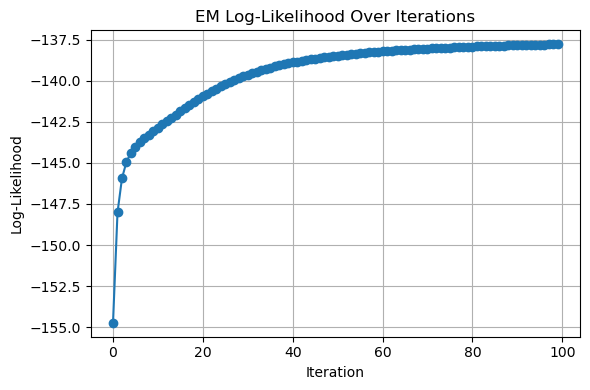

In [12]:
# Plot log-likelihood 
plt.figure(figsize=(6, 4))
plt.plot(loglikelihoods, marker='o')
plt.title("EM Log-Likelihood Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# Print learned parameters (rounded)
print("\n=== Learned Parameters ===")

print("A:\n", np.round(kf.observation_matrices, 2))
print("B:\n", np.round(kf.transition_matrices, 2))
print("Sigma:\n", np.round(kf.observation_covariance, 2))
print("Gamma:\n", np.round(kf.transition_covariance, 2))


=== Learned Parameters ===
A:
 [[ 1.32 -0.67]
 [ 0.67  0.53]
 [ 0.    0.47]
 [ 0.21  1.38]
 [-0.4   1.64]
 [ 0.8  -0.31]]
B:
 [[0.86 0.21]
 [0.19 0.64]]
Sigma:
 [[ 0.28  0.12  0.04 -0.06 -0.02 -0.  ]
 [ 0.12  0.39  0.02 -0.15 -0.18  0.07]
 [ 0.04  0.02  0.21  0.02  0.04  0.13]
 [-0.06 -0.15  0.02  0.32  0.1   0.08]
 [-0.02 -0.18  0.04  0.1   0.23  0.1 ]
 [-0.    0.07  0.13  0.08  0.1   0.26]]
Gamma:
 [[ 0.01 -0.02]
 [-0.02  0.05]]
